# Features extraction from degree>1 and shock propagation through the network

This notebook starts from the output generated at step 4 (04_trades_featureEng.ipynb), enriching the dataset with new features extracted from the network modelled as a bond graph

In [1]:
import numpy as np
import pandas as pd 
from os import environ
from network_analysis_exp import *
from network_bond_graph import *
from network_modelling import *
import networkx as nx
import seaborn as sns

## Importing data

In [2]:
user = environ["USERNAME"]
datafolder = ".."+"/data/".format(user)
filename = "03_instrumentsdf_deg1stats.pkl"

df = pd.read_pickle(datafolder+filename)

## Flow Graph modelling for impairment_1

### Adding effort and flow as instrument features - impairment1

- The effort at each edge is calculated as the sum of purchase amounts between a given buyer and a given seller.  
- The flow at each edge is calculated as the sum of the total impairment between the two companies divided by the sum of the invoice amounts.

In [3]:
edge_effort = df.groupby(['customer_name_1', 'debtor_name_1']).apply(lambda x:np.nansum(x.purchase_amount))
edge_flow = df.groupby(['customer_name_1', 'debtor_name_1']).apply(lambda x:np.nansum(x.total_impairment)/np.nansum(x.invoice_amount))

In [4]:
edge_flow[edge_flow.isnull()]=0

In [5]:
df['imp_edge_eff'] = [edge_effort[(df.loc[i, 'customer_name_1'], df.loc[i, 'debtor_name_1'])] for i in df.index]
df['imp_edge_flow'] = [edge_flow[(df.loc[i, 'customer_name_1'], df.loc[i, 'debtor_name_1'])] for i in df.index]
df['imp_edge_eff'] = df['imp_edge_eff'].replace([np.inf, -np.inf], 0)
df['imp_edge_flow'] = df['imp_edge_flow'].replace([np.inf, -np.inf], 0)

### 1. Undirected

Flows go from buyer to seller. There are parallel edges with opposite directions for hybrid cases.  
The graph will be initially modelled as an undirected graph since some of the networkx functions don't work on directed.

In [6]:
g = nx.Graph() #some networkx functions only work on undirected graphs

for cus in df.customer_name_1.unique():
    for debt in df.loc[df.customer_name_1==cus, 'debtor_name_1'].unique():
        
        df_tmp = df[df.customer_name_1==cus]
        df_tmp2 = df_tmp[df_tmp.debtor_name_1==debt]
        g.add_edge(debt, cus)

### 2. Adding impairment_1 features derived from bond graph formalims

In [7]:
df = build_bgtfeat(df,g)

In [8]:
df.describe()

,invoice_amount,purchase_amount,purchase_amount_open,discharge_amount,document_stack_id,test_characteristic_id,bill_id,purchase_examination,deduction_amount,nrecords,...,c_repaid_r,c_impaired1_r,c_pastdue90_r,c_pastdue180_r,imp_edge_eff,imp_edge_flow,imp_d_node_flow,imp_c_node_eff,imp_node_flow,imp_energy
count,5.982000e+04,5.982000e+04,5.982000e+04,2696.000000,59820.000000,1803.000000,59820.000000,11975.000000,47603.000000,59820.000000,...,5.969200e+04,5.969100e+04,59690.000000,59690.000000,5.982000e+04,59820.000000,59820.000000,5.982000e+04,59820.000000,5.982000e+04
mean,6.840900e+03,5.494234e+03,8.477222e+02,7384.895312,9937.816165,5.013866,37925.601204,25.601754,12.552649,2.531010,...,inf,inf,0.020103,0.010856,5.291119e+05,0.014529,2.347308,1.238718e+09,25.118850,8.159791e+09
std,2.760891e+04,2.603158e+04,1.012066e+04,12381.438747,5677.861583,0.116966,21035.770834,30.181423,412.591017,1.519459,...,NaN,NaN,0.054436,0.035920,8.885848e+05,0.059556,6.260445,1.424855e+09,19.305044,2.003589e+10
min,5.110000e+00,0.000000e+00,0.000000e+00,0.010000,1.000000,5.000000,1.000000,4.000000,0.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,1.519963e+03,4.328875e+02,0.000000e+00,390.912500,5542.000000,5.000000,20607.750000,14.000000,0.000000,2.000000,...,4.556052e-01,0.000000e+00,0.000000,0.000000,3.446470e+04,0.000000,0.000000,2.171897e+08,5.075884,2.287730e+07
50%,2.216450e+03,2.016150e+03,0.000000e+00,2233.450000,9842.000000,5.000000,39460.500000,14.000000,0.000000,2.000000,...,6.812315e-01,3.213958e-03,0.000738,0.000000,1.835365e+05,0.000000,0.000000,3.894150e+08,24.886577,3.284329e+08
75%,4.221188e+03,2.871200e+03,0.000000e+00,7894.417500,14654.000000,5.000000,55796.250000,14.000000,0.000000,3.000000,...,7.870435e-01,7.037102e-03,0.010881,0.004194,6.348421e+05,0.004442,1.074920,2.226492e+09,42.838886,4.057329e+09
max,1.777910e+06,1.777910e+06,1.146584e+06,128552.400000,19868.000000,6.000000,72355.000000,165.000000,33011.650000,143.000000,...,inf,inf,1.000000,0.823529,6.307533e+06,1.000346,36.305373,5.313150e+09,66.306407,9.161020e+10


In [9]:
df.head().transpose()

uid,2744:79/231,2861:79/232,2932:79/233,1472:489/688,2042:512/645
customer_id,2004008,2004008,2004008,2004009,2004009
customer_name_1,Castillo GmbH,Castillo GmbH,Castillo GmbH,Orpheus Wyandotte Supply LLC,Orpheus Wyandotte Supply LLC
debtor_id,79,79,79,489,512
debtor_name_1,Sana Hyannis Sarl,Sana Hyannis Sarl,Sana Hyannis Sarl,Isfahan SA,Aldrich Chloe GmbH
invoice_number,2744,2861,2932,1472,2042
invoice_date,2013-07-23 00:00:00,2013-07-30 00:00:00,2013-08-06 00:00:00,2013-08-13 00:00:00,2013-08-13 00:00:00
due_date,2013-08-02 00:00:00,2013-08-09 00:00:00,2013-08-16 00:00:00,2013-08-23 00:00:00,2013-08-23 00:00:00
invoice_amount,913.7,2233.45,1370.5,9195.1,4594.6
purchase_amount,0,0,0,0,0
purchase_amount_open,0,0,0,0,0


### 3. Isolating graph components

In [10]:
a = nx.connected_components(g)
components = [c for c in sorted(a, key=len, reverse=True)]

### 4. Directed graph

In [11]:
directed_graphs = create_directed_graphs(components, df, 10**6)

In [12]:
#dictionary of independent components
comp_dict = dict(zip(range(len(components)), directed_graphs)) #each component corresponds to a number

In [13]:
capacity_list = []
weight_list = []

for line in nx.generate_edgelist(comp_dict[0]):
    #print(line)
    capacity_list.append(int(line.split(':')[1].split(',')[0].strip()))
    weight_list.append(int(line.split(':')[2].split('}')[0].strip()))


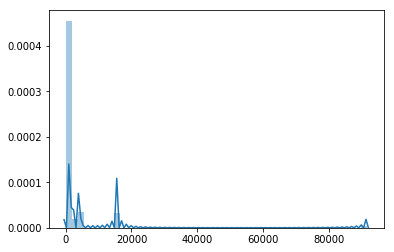

In [14]:
sns.distplot(capacity_list, bins=50)

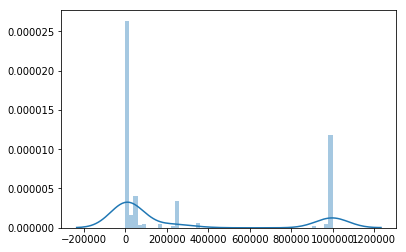

In [15]:
sns.distplot(weight_list, bins=50)

### 5. hybrids and their connections

In [16]:
#the nodes that are both buyers and sellers
customers = df.customer_name_1.unique()
debtors = df.debtor_name_1.unique()
hybrids = [v for v in customers if v in debtors]
hybrids

['Cooperative Inventors Corporation',
 'Remington Muskegon Corporation',
 'McKesson Gumptia Inc.',
 'Telex Inc.',
 'Johansen Wilhelmina Sarl',
 'Alva Apprentices and Pigeonberries SA',
 'Universal Societies Ltd',
 'DARPA Elijah Co.',
 'Katharine Corporation',
 'Tananarive Flintlocks Inc.',
 'Irma SA',
 'Sioux Oslo SA',
 'Rankine Assyria GmbH',
 'Blvd SA',
 'Inman Workbenches and Coquinas Co.']

Hybrids and debtors nodes connected to them are particularly important because they work as capacitors, and as such contribute to the diffusion of a certain credit event in the system creating a chain.  
The debtors directly connected to them can be seen as a starting point of the flow, which will be passed through the capacitors (hybrid nodes) to reach other nodes.
The receiver nodes will be other hybrids or customers (not debtors).  
Nodes wich have the seller role alone are considered as flow sinks (the energy leaves the system through them) or accumulators (without dissipation capability).

In [17]:
# finding the debtor nodes connected to hybrids
connected_to_hyb = [d for d in debtors if len(node_neighborhood(g, d, 1, hybrids))>1]

In [18]:
len(connected_to_hyb)

547

### 6. Flow modelling

In [19]:
#all debtors connected with hybrids with sources of flow >0
df_flow_chain = df[df.debtor_name_1.isin(connected_to_hyb) & df.imp_energy>0] 

In [20]:
conn_to_hyb_sources = df_flow_chain.debtor_name_1.unique() #nodes having flow>0 and connected to hybrids

In [21]:
len(conn_to_hyb_sources)

528

In [22]:
# for each debtor node connected to hybrids, we find the maximum 'chain degree' (the last node reached by the flow of that particular source)
max_degrees = [including_degree(g, nn, hybrids, comp_dict) for nn in conn_to_hyb_sources]

In [23]:
#exlcuding the debtors from the last reached nodes, since only customers can accumulate/dissipate or transmit (if they are hybrids) the flow
max_degrees = pd.Series(max_degrees).apply(lambda x:(x[0], x[1], list(x[2].intersection(set(df.customer_name_1))), x[3]))

In [24]:
#this dictionary will have as keys the starting buyers nodes, as values tuples of (farest flow degree, last hybrid contained in the path, last nodes reached 1 degree after the last hybrids)
dict_start_end = dict(zip(conn_to_hyb_sources, max_degrees))

At this point each "flow path" is detected and the total flow will be computed as a "graph overlapping": for each path a new grah is created, with "sub-flow values" assigned to the respective edges.
In order to obtain the graph containing the total flow, the sum of the subflows is used.

In [25]:
#create flow graphs
graphs = create_flow_graphs(dict_start_end, comp_dict)

2368 graphs successfully created


In [26]:
print('{} graphs successfully created'.format(len(graphs)))

2368 graphs successfully created


In [27]:
#identifying graphs with flow>0 and total flow computed
values_list = [] #list of values for each graph
pos_graphs = set() #set of graphs having positive flow values

for n in range((len(graphs))): #for each graph
    for v in graphs[n].values(): #for each set of values at each path of each graph
        for vv in v.values(): #for each value
            if vv>0:
                pos_graphs.add(n) 
    values_list.append(sum([sum(list(v.values())) for v in graphs[n].values()]))
print(pos_graphs)
print("Total calculated shock flow is {} over {} graphs with positive flow value for impairment".format(sum(values_list), len(pos_graphs)))

{1, 2, 1537, 516, 1539, 518, 14, 16, 1552, 18, 1554, 20, 536, 29, 1568, 1570, 1060, 1062, 39, 2094, 1583, 2095, 561, 1585, 563, 1075, 1077, 60, 62, 64, 577, 1600, 579, 1091, 1093, 1602, 2119, 1615, 592, 1617, 82, 594, 84, 1626, 1627, 1628, 99, 1640, 1130, 1642, 114, 627, 116, 629, 1655, 1144, 1657, 1146, 1659, 1660, 642, 644, 134, 1159, 136, 1161, 1672, 1674, 1677, 1679, 659, 661, 1174, 151, 1176, 153, 2200, 155, 1691, 1693, 1696, 1697, 676, 1189, 678, 167, 1191, 169, 1713, 691, 1204, 693, 1206, 183, 1715, 185, 1222, 1735, 1224, 202, 715, 717, 1745, 217, 219, 1758, 1760, 737, 739, 1251, 1252, 235, 237, 750, 1264, 1776, 1266, 1778, 759, 250, 252, 1788, 1789, 773, 775, 1801, 1290, 267, 1292, 1803, 1805, 1295, 1296, 1297, 1298, 1299, 1300, 789, 791, 1817, 1306, 1819, 285, 287, 1311, 1314, 805, 1317, 807, 307, 820, 1333, 822, 1340, 1345, 326, 1863, 1359, 1361, 338, 852, 352, 354, 873, 875, 1392, 370, 1394, 372, 1406, 1408, 385, 387, 1924, 902, 904, 1419, 403, 405, 920, 1433, 922, 418, 420,

In [28]:
#creating a dictionaries of flow overlaps + check
#it will contain the terminal nodes between edges having positive flow with relative flow value
sum_dict={}

for pg in pos_graphs:
    check = graphs[pg]

    for j in check.keys():
        for k in check[j]:
            if check[j][k]>0:
                #print('graph '+str(pg),'-',j,'-', k,'-', check[j])
                if (j,k) not in sum_dict.keys():
                    sum_dict[(j,k)] = check[j][k]
                else:
                    sum_dict[(j,k)] += check[j][k]

In [29]:
#for each graph component, the flow is added at each edge as capacity
#all edges flow (addition to the sum_dict of the starting static flows as final overlap)
for j in comp_dict.keys():
    for e in comp_dict[j].edges:
        if e not in sum_dict.keys():
            sum_dict[e]=comp_dict[j].get_edge_data(e[0], e[1])['capacity']
        else:
            sum_dict[e]+=comp_dict[j].get_edge_data(e[0], e[1])['capacity']

In [30]:
#assigning the flow value to instruments as a new feature
for edge in sum_dict.keys():
    df.loc[(df.customer_name_1==edge[1]) & (df.debtor_name_1==edge[0]), 'flow_shock_imp1'] = sum_dict[edge]

In [31]:
df.head().transpose()

uid,2744:79/231,2861:79/232,2932:79/233,1472:489/688,2042:512/645
customer_id,2004008,2004008,2004008,2004009,2004009
customer_name_1,Castillo GmbH,Castillo GmbH,Castillo GmbH,Orpheus Wyandotte Supply LLC,Orpheus Wyandotte Supply LLC
debtor_id,79,79,79,489,512
debtor_name_1,Sana Hyannis Sarl,Sana Hyannis Sarl,Sana Hyannis Sarl,Isfahan SA,Aldrich Chloe GmbH
invoice_number,2744,2861,2932,1472,2042
invoice_date,2013-07-23 00:00:00,2013-07-30 00:00:00,2013-08-06 00:00:00,2013-08-13 00:00:00,2013-08-13 00:00:00
due_date,2013-08-02 00:00:00,2013-08-09 00:00:00,2013-08-16 00:00:00,2013-08-23 00:00:00,2013-08-23 00:00:00
invoice_amount,913.7,2233.45,1370.5,9195.1,4594.6
purchase_amount,0,0,0,0,0
purchase_amount_open,0,0,0,0,0


## Flow graph modelling for pastdue90 (repeating the above process for pastdue_90)

In [32]:
edge_effort_2 = df.groupby(['customer_name_1', 'debtor_name_1']).apply(lambda x:np.nansum(x.payment_date_mismatch)) 

In [33]:
df['p90_edge_eff'] = [edge_effort_2[(df.loc[i, 'customer_name_1'], df.loc[i, 'debtor_name_1'])] for i in df.index]
df['p90_edge_eff'] = df['p90_edge_eff'].replace([np.inf, -np.inf, np.nan], 0)
df['p90_edge_flow'] = df.cd_pastdue90_r.replace([np.inf, -np.inf, np.nan], 0)

In [ ]:
df = build_bgtfeat(df, g, edge_flow='p90_edge_flow', edge_eff='p90_edge_eff', node_flow='p90_node_flow', energy='p90_energy',
                      c_node_eff='p90_c_node_eff', d_node_flow='p90_d_node_flow')

In [62]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
invoice_amount,59820.0,6.840900e+03,2.760891e+04,5.110000e+00,1.519963e+03,2.216450e+03,4.221188e+03,1.777910e+06
purchase_amount,59820.0,5.494234e+03,2.603158e+04,0.000000e+00,4.328875e+02,2.016150e+03,2.871200e+03,1.777910e+06
purchase_amount_open,59820.0,8.477222e+02,1.012066e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.146584e+06
discharge_amount,2696.0,7.384895e+03,1.238144e+04,1.000000e-02,3.909125e+02,2.233450e+03,7.894418e+03,1.285524e+05
document_stack_id,59820.0,9.937816e+03,5.677862e+03,1.000000e+00,5.542000e+03,9.842000e+03,1.465400e+04,1.986800e+04
test_characteristic_id,1803.0,5.013866e+00,1.169663e-01,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,6.000000e+00
bill_id,59820.0,3.792560e+04,2.103577e+04,1.000000e+00,2.060775e+04,3.946050e+04,5.579625e+04,7.235500e+04
purchase_examination,11975.0,2.560175e+01,3.018142e+01,4.000000e+00,1.400000e+01,1.400000e+01,1.400000e+01,1.650000e+02
deduction_amount,47603.0,1.255265e+01,4.125910e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.301165e+04
nrecords,59820.0,2.531010e+00,1.519459e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.430000e+02


## Modelling the directed graphs

Flows go from buyer to seller. There are parallel edges with opposite directions for hybrid cases.

## Modelling the connected components as digraphs - pastdue90

In [53]:
df.p90_energy.describe()

count    5.982000e+04
mean     1.705741e+07
std      7.644800e+07
min     -1.154616e+06
25%      0.000000e+00
50%      3.975117e+03
75%      3.275870e+05
max      3.717419e+08
Name: p90_energy, dtype: float64

In [ ]:
directed_graphs_p90 = create_directed_graphs(components, df, 10**4, 'p90_energy')

#dictionary of independent components
comp_dict_p90 = dict(zip(range(len(components)), directed_graphs_p90)) #each component corresponds to a number

#all debtors connected with hybrids with sources of flow >0
df_flow_chain2 = df[df.debtor_name_1.isin(connected_to_hyb) & df.p90_energy>0] 
conn_to_hyb_sources_p90 = df_flow_chain2.debtor_name_1.unique() #nodes having flow>0 and connected to hybrids

# for each debtor node connected to hybrids, we find the maximum 'chain degree' (the last node reached by the flow of that particular source)
max_degrees = [including_degree(g, nn, hybrids, comp_dict_p90) for nn in conn_to_hyb_sources]

#exlcuding the debtors from the last reached nodes, since only customers can accumulate/dissipate or transmit (if they are hybrids) the flow
max_degrees = pd.Series(max_degrees).apply(lambda x:(x[0], x[1], list(x[2].intersection(set(df.customer_name_1))), x[3]))

#this dictionary will have as keys the starting buyers nodes, as values tuples of (farest flow degree, last hybrid contained in the path, last nodes reached 1 degree after the last hybrids)
dict_start_end = dict(zip(conn_to_hyb_sources_p90, max_degrees))

#flow graphs
graphs_p90 = create_flow_graphs(dict_start_end, comp_dict_p90)
print('{} graphs successfully created'.format(len(graphs_p90)))

1767 graphs successfully created


In [74]:
#identifying graphs with flow>0 and total flow computed
ss = []

gg = set()
for n in range((len(graphs))):
    for v in graphs[n].values():
        for vv in v.values():
            if vv>0:
                gg.add(n)
    ss.append(sum([sum(list(v.values())) for v in graphs[n].values()]))
print(gg)
print("Total calculated shock flow is {} over {} graphs with flow>0".format(sum(ss), len(gg)))

{2, 1538, 6, 1031, 520, 1035, 1549, 1553, 1047, 1051, 541, 545, 1570, 1571, 1573, 1577, 43, 557, 47, 561, 1588, 1592, 572, 576, 65, 1089, 1602, 1603, 69, 1605, 1609, 1100, 1104, 1620, 86, 1622, 1624, 1115, 1628, 607, 1119, 97, 611, 101, 1639, 1640, 1130, 622, 1134, 1646, 626, 1650, 117, 121, 1145, 1149, 639, 643, 134, 1670, 1160, 138, 1164, 656, 148, 660, 150, 1684, 1687, 154, 1178, 1691, 1182, 671, 675, 166, 170, 1706, 1710, 693, 1720, 697, 1721, 1723, 188, 1727, 1217, 1218, 1220, 200, 1224, 1737, 715, 204, 1739, 719, 1743, 1753, 218, 1754, 1244, 1755, 222, 1756, 1248, 1757, 1758, 1760, 1761, 1762, 1763, 1764, 233, 746, 1259, 1260, 237, 750, 1261, 1262, 1263, 754, 1264, 1270, 1275, 253, 766, 770, 1284, 266, 270, 782, 786, 1298, 1303, 1307, 797, 1311, 801, 291, 310, 823, 1334, 1338, 323, 1349, 841, 1353, 333, 845, 337, 1365, 351, 863, 1378, 355, 867, 1380, 1384, 366, 878, 370, 882, 1398, 1402, 384, 899, 388, 903, 1421, 399, 1425, 914, 403, 1429, 918, 415, 1440, 419, 932, 1444, 943, 145

In [ ]:
#dictionaries of flow overlaps + check
sum_dict={}

for h in gg:
    check = graphs[h]

    for j in check.keys():
        for k in check[j]:
            if check[j][k]>0:
                #print('graph '+str(h),'-',j,'-', k,'-', check[j])
                if (j,k) not in sum_dict.keys():
                    sum_dict[(j,k)] = check[j][k]
                else:
                    sum_dict[(j,k)] += check[j][k]

In [76]:
comp_dict[0].get_edge_data('Ancon Akkord GmbH', 'C.D.E. Group AG')

{'capacity': 1, 'weight': 10000}

In [77]:
#all edges flow (addition to the sum_dict of the starting static flows as final overlap)
for j in comp_dict.keys():
    for e in comp_dict[j].edges:
        if e not in sum_dict.keys():
            sum_dict[e]=comp_dict[j].get_edge_data(e[0], e[1])['capacity']
        else:
            sum_dict[e]+=comp_dict[j].get_edge_data(e[0], e[1])['capacity']

In [78]:
#assigning the flow value to instruments as a new feature
for edge in sum_dict.keys():
    df.loc[(df.customer_name_1==edge[1]) & (df.debtor_name_1==edge[0]), 'flow_shock_p90'] = sum_dict[edge]

In [79]:
df.head().transpose()

uid,2744:79/231,2861:79/232,2932:79/233,1472:489/688,2042:512/645
customer_id,2004008,2004008,2004008,2004009,2004009
customer_name_1,jobs united GmbH,jobs united GmbH,jobs united GmbH,PM Personal GmbH,PM Personal GmbH
debtor_id,79,79,79,489,512
debtor_name_1,Quadroni Linard,Quadroni Linard,Quadroni Linard,Style Interiors,Elektropartner AG
invoice_number,2744,2861,2932,1472,2042
invoice_date,2013-07-23 00:00:00,2013-07-30 00:00:00,2013-08-06 00:00:00,2013-08-13 00:00:00,2013-08-13 00:00:00
due_date,2013-08-02 00:00:00,2013-08-09 00:00:00,2013-08-16 00:00:00,2013-08-23 00:00:00,2013-08-23 00:00:00
invoice_amount,913.7,2233.45,1370.5,9195.1,4594.6
purchase_amount,0,0,0,0,0
purchase_amount_open,0,0,0,0,0


## Adding effort and flow as instrument features - pastdue180

In [80]:
#first experiment for pastdue_90
#effort = normal volume of node (total purchased amount)
#flow = impaired proportion

#edge_effort_2 is still defining the effort
#for the edge_flow the ratio of pastdues180 will be considered

In [81]:
df['p180_edge_flow'] = df.cd_pastdue180_r.replace([np.inf, -np.inf, np.nan], 0)

In [82]:
def build_bgtfeat_p180(df, g, degree=1):
    #customer nodes related attributes will be effort and energy
    #node_flow will be used to calculate the energy in the node
    #this function create attributes for impairment_1 predictions
    
    #debtors related attributes will be whole potential flow
    for d in df.debtor_name_1.unique():
        df.loc[df.debtor_name_1==d, 'p180_d_node_flow'] = df.loc[df.debtor_name_1==d, 'p180_edge_flow'].sum()
    
    for c in df.customer_name_1.unique():
        df.loc[df.customer_name_1==c, 'p180_node_flow'] = np.nansum(df.loc[df.customer_name_1==c, 'p180_edge_flow'])
        df.loc[df.customer_name_1==c, 'p180_energy'] = np.nansum(df.loc[df.customer_name_1==c, 'p90_edge_eff']*df.loc[df.customer_name_1==c, 'p180_d_node_flow'])
        
    
        if degree>1:
            for d in range(2, degree+1):
                neighborhood = node_neighborhood(g,c,d,n_only=True)
                p180_node_flow = 'p180_totd_node_flow_deg'+str(d)
                df.loc[df.customer_name_1==c, p180_node_flow] = df.loc[df.debtor_name_1.isin(neighborhood)|df.customer_name_1.isin(neighborhood), 'p180_edge_flow'].sum()

    

In [83]:
build_bgtfeat_p180(df,g,1)

In [84]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
invoice_amount,59820.0,6.840900e+03,2.760891e+04,5.110000e+00,1.519963e+03,2.216450e+03,4.221188e+03,1.777910e+06
purchase_amount,59820.0,5.494234e+03,2.603158e+04,0.000000e+00,4.328875e+02,2.016150e+03,2.871200e+03,1.777910e+06
purchase_amount_open,59820.0,8.477222e+02,1.012066e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.146584e+06
discharge_amount,2696.0,7.384895e+03,1.238144e+04,1.000000e-02,3.909125e+02,2.233450e+03,7.894418e+03,1.285524e+05
document_stack_id,59820.0,9.937816e+03,5.677862e+03,1.000000e+00,5.542000e+03,9.842000e+03,1.465400e+04,1.986800e+04
test_characteristic_id,1803.0,5.013866e+00,1.169663e-01,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,6.000000e+00
bill_id,59820.0,3.792560e+04,2.103577e+04,1.000000e+00,2.060775e+04,3.946050e+04,5.579625e+04,7.235500e+04
purchase_examination,11975.0,2.560175e+01,3.018142e+01,4.000000e+00,1.400000e+01,1.400000e+01,1.400000e+01,1.650000e+02
deduction_amount,47603.0,1.255265e+01,4.125910e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.301165e+04
nrecords,59820.0,2.531010e+00,1.519459e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.430000e+02


## Modelling the directed graphs

Flows go from buyer to seller. There are parallel edges with opposite directions for hybrid cases.

## Modelling the connected components as digraphs - pastdue180

In [85]:
df.p180_energy.describe()

count    5.982000e+04
mean     4.674226e+06
std      2.099393e+07
min     -7.086945e+05
25%      0.000000e+00
50%      0.000000e+00
75%      2.563561e+04
max      1.020563e+08
Name: p180_energy, dtype: float64

In [86]:
df.p180_edge_flow.dtypes

dtype('float64')

In [88]:
directed_graphs = []
red_coeff = 10**5
for comp in components:
    di_g = nx.DiGraph()
    
    for cus in df.loc[df.customer_name_1.isin(comp), 'customer_name_1'].unique():
        df_tmp = df[df.customer_name_1==cus]

        
        for debt in df_tmp['debtor_name_1'].unique():
            
            if cus!=debt: #avoiding self-loops

                df_tmp2 = df_tmp[df_tmp.debtor_name_1==debt]
                flow = round(sorted(list(df_tmp2.p180_energy.unique()))[-1]/red_coeff,3)
                
                if abs(flow)<1:
                    if flow==0:
                        flow=1
                    else:
                        flow=np.sign(flow)*1
                    weight_=red_coeff
                else:
                    weight_ = abs(round(red_coeff/flow,3))
                
                di_g.add_edge(debt, cus,capacity=int(flow), weight=int(weight_))

    directed_graphs.append(di_g)

In [89]:
#dictionary of independent components
comp_dict = dict(zip(range(len(components)), directed_graphs)) #each component corresponds to a number

In [90]:
#quick check on modelling
for line in nx.generate_edgelist(comp_dict[1]):
    print(line)

AdNovum Informatik AG GHR Global Human Resources AG {'capacity': 1, 'weight': 100000}
Swiss Reinsurace Company Ltd. GHR Global Human Resources AG {'capacity': 1, 'weight': 100000}
TWINT AG GHR Global Human Resources AG {'capacity': 1, 'weight': 100000}
Swiss Re Management Ltd. GHR Global Human Resources AG {'capacity': 1, 'weight': 100000}
Inventx AG GHR Global Human Resources AG {'capacity': 1, 'weight': 100000}
Stadt Zürich GHR Global Human Resources AG {'capacity': 1, 'weight': 100000}
Stadt Zürich mr.clean facility solutions ag {'capacity': 21, 'weight': 4731}
Swisscom (Schweiz) AG GHR Global Human Resources AG {'capacity': 1, 'weight': 100000}
WIR Bank GHR Global Human Resources AG {'capacity': 1, 'weight': 100000}
Bundesamt für Informatik GHR Global Human Resources AG {'capacity': 1, 'weight': 100000}
Siemens Schweiz AG GHR Global Human Resources AG {'capacity': 1, 'weight': 100000}
Informatik Service Center ISC-EJPD GHR Global Human Resources AG {'capacity': 1, 'weight': 100000}

In [92]:
#all debtors connected with hybrids with sources of flow >0
df_flow_chain3 = df[df.debtor_name_1.isin(connected_to_hyb) & df.p180_energy>0] 

In [93]:
conn_to_hyb_sources = df_flow_chain3.debtor_name_1.unique() #nodes having flow>0 and connected to hybrids

In [94]:
# for each debtor node connected to hybrids, we find the maximum 'chain degree' (the last node reached by the flow of that particular source)
max_degrees = [including_degree(g, nn, hybrids) for nn in conn_to_hyb_sources]

In [95]:
#exlcuding the debtors from the last reached nodes, since only customers can accumulate/dissipate or transmit (if they are hybrids) the flow
max_degrees = pd.Series(max_degrees).apply(lambda x:(x[0], x[1], list(x[2].intersection(set(df.customer_name_1))), x[3]))

In [96]:
#this dictionary will have as keys the starting buyers nodes, as values tuples of (farest flow degree, last hybrid contained in the path, last nodes reached 1 degree after the last hybrids)
dict_start_end = dict(zip(conn_to_hyb_sources, max_degrees))

In [97]:
comp_dict[10].get_edge_data('Davro Steel Ltd', 'ABC Steel Products GBP')

{'capacity': 1, 'weight': 100000}

In [98]:
graphs = create_flow_graphs(dict_start_end)

In [99]:
print('{} graphs successfully created'.format(len(graphs)))

1615 graphs successfully created


In [100]:
#identifying graphs with flow>0 and total flow computed
ss = []

gg = set()
for n in range((len(graphs))):
    for v in graphs[n].values():
        for vv in v.values():
            if vv>0:
                gg.add(n)
    ss.append(sum([sum(list(v.values())) for v in graphs[n].values()]))
print(gg)
print("Total calculated shock flow is {} over {} graphs with flow>0".format(sum(ss), len(gg)))

{514, 1539, 1034, 525, 1038, 529, 1553, 19, 23, 1049, 1564, 1053, 1568, 1064, 41, 1535, 1068, 45, 1579, 1583, 560, 564, 1079, 1594, 1083, 60, 1598, 575, 579, 71, 1095, 1608, 1609, 75, 1099, 1610, 1611, 591, 1612, 595, 88, 92, 607, 1120, 1122, 611, 1126, 103, 107, 622, 626, 117, 119, 1145, 123, 1149, 644, 134, 1159, 648, 1160, 138, 1161, 1162, 1163, 1164, 1170, 1175, 666, 156, 670, 1183, 167, 171, 1197, 1202, 694, 1206, 184, 696, 1210, 188, 700, 199, 712, 203, 716, 1232, 1236, 727, 217, 731, 1247, 1251, 230, 742, 234, 746, 1263, 1274, 251, 1276, 768, 1280, 780, 269, 1294, 784, 1298, 282, 1309, 799, 1313, 291, 803, 1317, 295, 814, 1328, 818, 307, 1332, 311, 829, 1342, 833, 322, 1346, 1347, 326, 1351, 1355, 844, 848, 340, 1366, 344, 1370, 862, 355, 1381, 359, 873, 1385, 877, 371, 1396, 375, 1400, 892, 896, 1411, 389, 1415, 393, 907, 911, 1426, 405, 1430, 409, 420, 424, 1449, 939, 1453, 943, 435, 439, 1464, 954, 1468, 958, 450, 454, 1479, 969, 1483, 973, 1494, 1496, 474, 1500, 1514, 1518, 

In [101]:
#dictionaries of flow overlaps + check
sum_dict={}

for h in gg:
    check = graphs[h]

    for j in check.keys():
        for k in check[j]:
            if check[j][k]>0:
                print('graph '+str(h),'-',j,'-', k,'-', check[j])
                if (j,k) not in sum_dict.keys():
                    sum_dict[(j,k)] = check[j][k]
                else:
                    sum_dict[(j,k)] += check[j][k]

graph 514 - Fortuna Personalberatung GmbH - Fortuna Payroll GmbH - {'Fortuna Payroll GmbH': 2}
graph 514 - BluePlan AG - Fortuna Personalberatung GmbH - {'Fortuna Personalberatung GmbH': 2, 'RG Baumanagement AG': 2}
graph 514 - BluePlan AG - RG Baumanagement AG - {'Fortuna Personalberatung GmbH': 2, 'RG Baumanagement AG': 2}
graph 514 - RG Baumanagement AG - Fortuna Payroll GmbH - {'Fortuna Personalberatung GmbH': 0, 'BluePlan AG': 0, 'P+P Personal AG': 0, 'Top Gipser AG': 0, 'Fortuna Payroll GmbH': 2}
graph 514 - Estermann AG - BluePlan AG - {'BluePlan AG': 4}
graph 1539 - Fortuna Personalberatung GmbH - Fortuna Payroll GmbH - {'Fortuna Payroll GmbH': 2}
graph 1539 - BluePlan AG - Fortuna Personalberatung GmbH - {'Fortuna Personalberatung GmbH': 2, 'RG Baumanagement AG': 2}
graph 1539 - BluePlan AG - RG Baumanagement AG - {'Fortuna Personalberatung GmbH': 2, 'RG Baumanagement AG': 2}
graph 1539 - RG Baumanagement AG - Fortuna Payroll GmbH - {'Fortuna Personalberatung GmbH': 0, 'BluePl

In [102]:
comp_dict[0].get_edge_data('Ancon Akkord GmbH', 'C.D.E. Group AG')

{'capacity': 1, 'weight': 100000}

In [103]:
#all edges flow (addition to the sum_dict of the starting static flows as final overlap)
for j in comp_dict.keys():
    for e in comp_dict[j].edges:
        if e not in sum_dict.keys():
            sum_dict[e]=comp_dict[j].get_edge_data(e[0], e[1])['capacity']
        else:
            sum_dict[e]+=comp_dict[j].get_edge_data(e[0], e[1])['capacity']

In [104]:
#assigning the flow value to instruments as a new feature
for edge in sum_dict.keys():
    df.loc[(df.customer_name_1==edge[1]) & (df.debtor_name_1==edge[0]), 'flow_shock_p180'] = sum_dict[edge]

In [105]:
df.head().transpose()

uid,2744:79/231,2861:79/232,2932:79/233,1472:489/688,2042:512/645
customer_id,2004008,2004008,2004008,2004009,2004009
customer_name_1,jobs united GmbH,jobs united GmbH,jobs united GmbH,PM Personal GmbH,PM Personal GmbH
debtor_id,79,79,79,489,512
debtor_name_1,Quadroni Linard,Quadroni Linard,Quadroni Linard,Style Interiors,Elektropartner AG
invoice_number,2744,2861,2932,1472,2042
invoice_date,2013-07-23 00:00:00,2013-07-30 00:00:00,2013-08-06 00:00:00,2013-08-13 00:00:00,2013-08-13 00:00:00
due_date,2013-08-02 00:00:00,2013-08-09 00:00:00,2013-08-16 00:00:00,2013-08-23 00:00:00,2013-08-23 00:00:00
invoice_amount,913.7,2233.45,1370.5,9195.1,4594.6
purchase_amount,0,0,0,0,0
purchase_amount_open,0,0,0,0,0


In [106]:
df.to_pickle(datafolder+'instruments_flow_2.pkl')